In [1]:
# this is the pipeline of phenotype analysis
import sys
import os
import pandas as pd
import json
sys.path.append('..')
import abd_profile
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
import matplotlib.pyplot as plt

In [2]:
sig_dir = '../result/immu/SE_sig'
se_dir = '../result/immu/SE'
outdir = '../result/immu/combine'
if not os.path.exists(outdir):
    os.makedirs(outdir)
sig_sp_dict = json.load(open(os.path.join(sig_dir,'cluster_sp.json')))
se_sp_dict = json.load(open(os.path.join(se_dir,'cluster_sp.json')))
sig_sp_dict['sig1'] = sig_sp_dict['sig1'].split(',')
sig_sp_dict['sig2'] = sig_sp_dict['sig2'].split(',')
se_sp_dict['supercluster_S3'] = se_sp_dict['supercluster_S3'].split(',')
se_sp_dict['cluster_S1-C20'] = se_sp_dict['cluster_S1-C20'].split(',')

# load num of sig
sig_sps = json.load(open(os.path.join(sig_dir,'existed_sp.json')))
se_sps = json.load(open(os.path.join(se_dir,'existed_sp.json')))


In [3]:
new_sp_dict = {}
new_sp_dict['pos'] = list(set(sig_sp_dict['sig2']).union(set(se_sp_dict['cluster_S1-C20'])))
new_sp_dict['neg'] = list(set(sig_sp_dict['sig1']).union(set(se_sp_dict['supercluster_S3'])))

sample_sps = {'pos':{}, 'neg':{}}
# neg
for sample in sig_sps['sig1'].keys():
    sp_list_sig = sig_sps['sig1'][sample].split(',')
    sp_list_se = se_sps['supercluster_S3'][sample].split(',')
    all_sp = list(set(sp_list_sig).union(set(sp_list_se)))
    sample_sps['neg'][sample] = all_sp

# pos 
for sample in sig_sps['sig2'].keys():
    sp_list_sig = sig_sps['sig2'][sample].split(',')
    sp_list_se = se_sps['cluster_S1-C20'][sample].split(',')
    all_sp = list(set(sp_list_sig).union(set(sp_list_se)))
    sample_sps['pos'][sample] = all_sp


In [4]:

score_df = pd.DataFrame(index= sample_sps['pos'].keys(), columns=['score'])
for sample in sample_sps['pos'].keys():
    pos = len(set(sample_sps['pos'][sample]).intersection(set(new_sp_dict['pos'])))/len(new_sp_dict['pos'])
    neg = len(set(sample_sps['neg'][sample]).intersection(set(new_sp_dict['neg'])))/len(new_sp_dict['neg'])
    score_df.loc[sample, 'score'] = (pos - neg +1)/2
score_df.to_csv(os.path.join(outdir, 'score_disc.tsv'), sep='\t')

In [5]:
# Cohort OS Sample_id TOPOB01 OS12
DS1 = pd.read_csv('../data/immu/DS1_oncology_clinical_data.csv', header=0)
DS1 = DS1[DS1['Cohort']=='Disc']
DS1.set_index('Sample_id', inplace=True)
DS1.dropna(subset=['OS12'], inplace=True)
DS1['Sample_id'] = DS1.index

pred_disc = pd.read_csv(os.path.join(outdir, 'score_disc.tsv'), sep='\t', header=0, index_col=0)
DS1['TOPOB01'] = pred_disc.loc[DS1.index, 'score']
DS1.to_csv(os.path.join(outdir, 'pred_disc.tsv'), sep='\t', index=False)
pred_DS1 = DS1[(DS1['TOPOB01'] <= 0.499) | (DS1['TOPOB01'] > 0.643)]
pred_DS1.to_csv(os.path.join(outdir, 'pred_valid.tsv'), sep='\t', index=False)

DS1.loc[DS1[DS1['TOPOB01'] <= 0.499].index, 'TOPOB01'] = 0
DS1.loc[DS1[DS1['TOPOB01'] > 0.643].index, 'TOPOB01'] = 1
pred_DS1 = DS1[(DS1['TOPOB01'] == 0) | (DS1['TOPOB01'] == 1)]
pred_DS1.to_csv(os.path.join(outdir, 'pred_binary_disc.tsv'), sep='\t', index=False)
print(len(pred_DS1[((pred_DS1['OS12']=='NR')&(pred_DS1['TOPOB01'] == 0))])/len(pred_DS1[pred_DS1['TOPOB01'] == 0]), len(pred_DS1[((pred_DS1['OS12']=='NR')&(pred_DS1['TOPOB01'] == 0))]), len(pred_DS1[pred_DS1['TOPOB01'] == 0]))
print(len(pred_DS1[((pred_DS1['OS12']=='NR')&(pred_DS1['TOPOB01'] == 1))])/len(pred_DS1[pred_DS1['TOPOB01'] == 1]), len(pred_DS1[((pred_DS1['OS12']=='NR')&(pred_DS1['TOPOB01'] == 1))]), len(pred_DS1[pred_DS1['TOPOB01'] == 1]))

# NR [64] < 0.50 < gray_zone [88] < 0.64 < R [78]
# auc = 0.680
# Prediction discovery: HR = 0.41 [0.28-0.61], p = 1.3e-05

0.65625 42 64
0.2948717948717949 23 78


SIG2:       SIG2_lower_0.95  SIG2_upper_0.95
0.5        15.713346        30.703485
SIG1:       SIG1_lower_0.95  SIG1_upper_0.95
0.5         3.287311             10.8


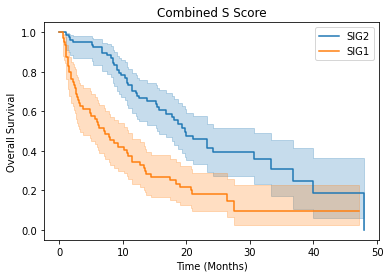

In [10]:
# draw and cox

kmf = KaplanMeierFitter()
kmf.fit(pred_DS1[pred_DS1['TOPOB01']==1]['OS'], event_observed=pred_DS1[pred_DS1['TOPOB01']==1]['Death'], label='SIG2')
ax = kmf.plot()
treatment_median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print('SIG2: ', treatment_median_confidence_interval_)

kmf.fit(pred_DS1[pred_DS1['TOPOB01']==0]['OS'], event_observed=pred_DS1[pred_DS1['TOPOB01']==0]['Death'], label = 'SIG1')
#共享一个画布
ax = kmf.plot(ax=ax)

control_median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print('SIG1: ', control_median_confidence_interval_)

plt.ylabel('Overall Survival')
plt.xlabel('Time (Months)')
plt.title('Combined S Score')
plt.savefig(os.path.join(outdir, 'OS_curve.pdf'), dpi=300, format='pdf')

In [7]:


# add akk
normal_n = 0
abnormal_n = 0
zero_n = 0
for sample in DS1.index:
    if DS1.loc[sample, 'TOPOB01'] < 1 and DS1.loc[sample, 'TOPOB01'] > 0:
        if DS1.loc[sample, 'AKK_TRICHO'] == 'Low':
            DS1.loc[sample, 'TOPOB01'] = 1
            normal_n += 1
        else:
            DS1.loc[sample, 'TOPOB01'] = 0
            if DS1.loc[sample, 'AKK_TRICHO'] == 'Zero':
                zero_n += 1
            abnormal_n += 1
DS1.to_csv(os.path.join(outdir, 'pred_disc_akk.tsv'), sep='\t', index=False)
print(normal_n, abnormal_n, normal_n/(normal_n+abnormal_n))
print(normal_n/230, abnormal_n/230)
print(zero_n/230, (abnormal_n-zero_n)/230)
print(len(DS1[((DS1['OS12']=='NR')&(DS1['TOPOB01'] == 0))])/len(DS1[DS1['TOPOB01'] == 0]))
print(len(DS1[((DS1['OS12']=='NR')&(DS1['TOPOB01'] == 1))])/len(DS1[DS1['TOPOB01'] == 1]))
print(len(DS1[DS1['TOPOB01'] == 0]))
print(len(DS1[DS1['TOPOB01'] == 1]))
# auc = 0.61

28 60 0.3181818181818182
0.12173913043478261 0.2608695652173913
0.21304347826086956 0.04782608695652174
0.5887096774193549
0.36792452830188677
124
106


In [8]:
for c,  slist in new_sp_dict.items():
    print(c, len(slist))

pos 32
neg 36
